In [8]:
%pip install nltk transformers torch annoy seaborn matplotlib scikit-learn PyPDF2 plotly



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
import PyPDF2
import os
import pickle
from tqdm import tqdm
from huggingface_hub import snapshot_download
import os
import numpy as np
import PyPDF2
from annoy import AnnoyIndex



from collections import defaultdict
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.nn import DataParallel
import torch
from paper_processing_for_embeddings import preprocess_and_read 

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aayushgupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aayushgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

# If multiple GPUs are available, use DataParallel
if torch.cuda.device_count() > 1:
    model = DataParallel(model)

model = model.to(device)



In [3]:
def embed_words_batch(words):
    inputs = tokenizer(words, padding=True, return_tensors='pt', truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the appropriate device
    outputs = model(**inputs)
    return outputs.hidden_states[-1][:, 0, :].detach().cpu().numpy()


In [8]:
def build_annoy_index(embeddings_dict):
    f = list(embeddings_dict.values())[0]['embedding'].shape[0]
    t = AnnoyIndex(f, 'angular')
    for i, (word, data) in enumerate(embeddings_dict.items()):
        t.add_item(i, data['embedding'])
    t.build(10)
    return t

def query_similar_words(query, index, embeddings_dict, top_n=5):
    query_embedding = embed_words_batch([query])[0]  # Embed the query word
    nearest_ids = index.get_nns_by_vector(query_embedding, top_n)

    similar_words_with_titles = []
    for i in nearest_ids:
        word = list(embeddings_dict.keys())[i]
        title = embeddings_dict[word]['file'].split('/')[-1]  # Extract the file name
        similar_words_with_titles.append((word, title))

    return similar_words_with_titles



In [5]:
with open('word_embeddings.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)


In [9]:
# Build Annoy index
annoy_index = build_annoy_index(embeddings_dict)

In [10]:
# Query for similar words
query_word = "gpt4"  # Replace with your query word
similar_words = query_similar_words(query_word, annoy_index, embeddings_dict, top_n=25)
print(f"Words similar to '{query_word}': {similar_words}")

Words similar to 'gpt4': [('GPT4', 'suspicionagent playing imperfect information games with theory of mind aware gpt4.pdf'), ('gpt4', 'benchmarking cognitive biases in large language models as evaluators.pdf'), ('GPT5', 'mixture of soft prompts for controllable data generation.pdf'), ('GPT/T5', 'claret pretraining a correlationaware contexttoevent transformer for eventcentric generation and classification.pdf'), ('GPT-P1', 'transforming sentiment analysis in the financial domain with chatgpt.pdf'), ('GPT3e', 'towards zerolabel language learning.pdf'), ('GPT3-c', 'large language models are latent variable models explaining and finding good demonstrations for incontext learning.pdf'), ('co/gpt2', 'flatnessaware prompt selection improves accuracy and sample efficiency.pdf'), ('LsNRL4', 'bioinformatics in plant breeding and research on disease resistance.pdf'), ('Lfpt5', 'distillation of encoderdecoder transformers for sequence labelling.pdf'), ('LFPT5', 'lfpt5 a unified framework for life

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans

def optimized_plot_embeddings(embeddings_dict, query, index, top_n=5):
    # Extract embeddings and corresponding words
    words, embeddings = zip(*[(word, data['embedding']) for word, data in embeddings_dict.items() if data['embedding'] is not None])

    # Randomly sample 1000 embeddings
    sample_size = min(100000, len(embeddings))  # Adjust sample size as needed
    sampled_indices = random.sample(range(len(embeddings)), sample_size)
    sampled_embeddings = [embeddings[i] for i in sampled_indices]
    sampled_words = [words[i] for i in sampled_indices]

    # Add the query embedding
    query_embedding = embeddings_dict.get(query, {'embedding': None})['embedding']
    if query_embedding is None:
        query_embedding = embed_words_batch([query])[0]  # Replace with your actual embedding function

    # Add nearest neighbors of the query
    nearest_neighbors_indices = index.get_nns_by_vector(query_embedding, top_n)
    nearest_neighbors_embeddings = [embeddings[i] for i in nearest_neighbors_indices]
    nearest_neighbors_words = [words[i] for i in nearest_neighbors_indices]

    # Combine sampled embeddings, query, and nearest neighbors
    extended_embeddings = np.vstack(sampled_embeddings + [query_embedding] + nearest_neighbors_embeddings)

    # TSNE for dimensionality reduction
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(extended_embeddings)

    # KMeans for cluster-based coloring
    num_clusters = 5  # Adjust as needed
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(tsne_results[:-1-top_n])  # Apply KMeans to the sampled embeddings only

    # Plotting
    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 8))

    # Scatter plot for sampled embeddings with cluster coloring
    scatter = plt.scatter(tsne_results[:-1-top_n, 0], tsne_results[:-1-top_n, 1], c=clusters, alpha=0.5, cmap='viridis')

    # Highlight the query
    plt.scatter(tsne_results[-1-top_n, 0], tsne_results[-1-top_n, 1], color='blue', marker='X', s=100)
    plt.annotate(query, (tsne_results[-1-top_n, 0], tsne_results[-1-top_n, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight nearest neighbors
    for i, word in enumerate(nearest_neighbors_words):
        nn_index = -top_n + i
        plt.scatter(tsne_results[nn_index, 0], tsne_results[nn_index, 1], color='red', edgecolors='black', s=100)
        # plt.annotate(word, (tsne_results[nn_index, 0], tsne_results[nn_index, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('t-SNE Visualization with Cluster-Based Coloring, Query, and Neighbors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter)  # Show color scale for clusters
    plt.show()

# Example usage
# Make sure to replace 'embed_words_batch', 'embeddings_dict', and 'annoy_index' with your actual variables
optimized_plot_embeddings(embeddings_dict, "gpt4", annoy_index, top_n=5)


NameError: name 'random' is not defined

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10006 samples in 0.002s...
[t-SNE] Computed neighbors for 10006 samples in 0.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10006
[t-SNE] Computed conditional probabilities for sample 2000 / 10006
[t-SNE] Computed conditional probabilities for sample 3000 / 10006
[t-SNE] Computed conditional probabilities for sample 4000 / 10006
[t-SNE] Computed conditional probabilities for sample 5000 / 10006
[t-SNE] Computed conditional probabilities for sample 6000 / 10006
[t-SNE] Computed conditional probabilities for sample 7000 / 10006
[t-SNE] Computed conditional probabilities for sample 8000 / 10006
[t-SNE] Computed conditional probabilities for sample 9000 / 10006
[t-SNE] Computed conditional probabilities for sample 10000 / 10006
[t-SNE] Computed conditional probabilities for sample 10006 / 10006
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.050415
[t-SNE] KL

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


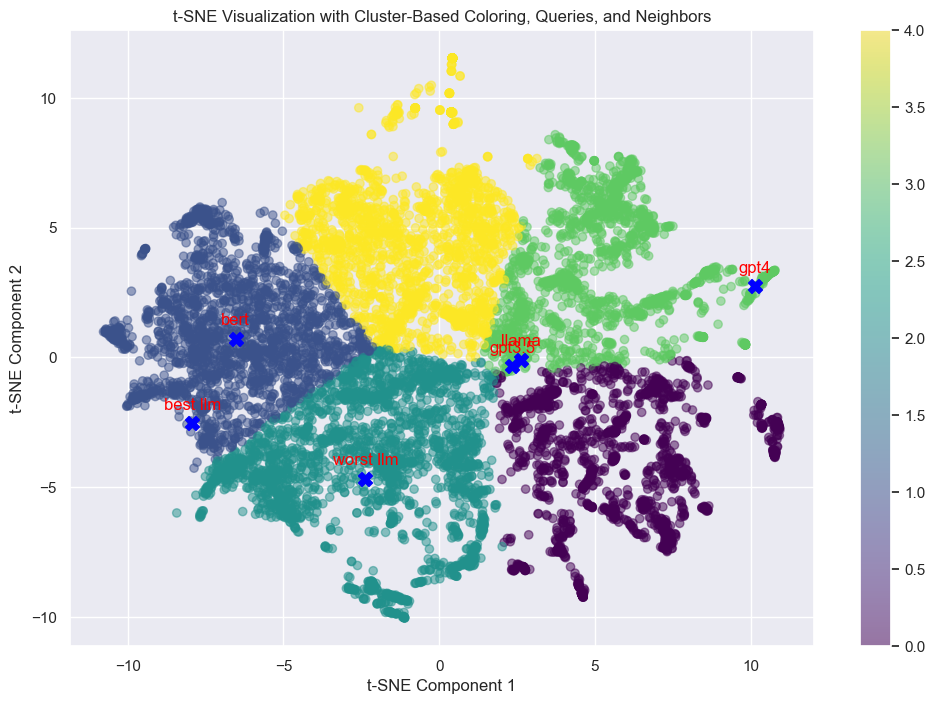

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans

def optimized_plot_embeddings(embeddings_dict, queries, index, top_n=5):
    # Extract embeddings and corresponding words
    words, embeddings = zip(*[(word, data['embedding']) for word, data in embeddings_dict.items() if data['embedding'] is not None])

    # Randomly sample 10k embeddings
    sample_size = min(10000, len(embeddings))
    sampled_indices = random.sample(range(len(embeddings)), sample_size)
    sampled_embeddings = [embeddings[i] for i in sampled_indices]
    sampled_words = [words[i] for i in sampled_indices]

    # Initialize lists for query embeddings and nearest neighbors
    query_embeddings = []
    nearest_neighbors_embeddings = []
    nearest_neighbors_words = []

    # Process each query
    for query in queries:
        # Get the query embedding
        query_embedding = embeddings_dict.get(query, {'embedding': None})['embedding']
        if query_embedding is None:
            query_embedding = embed_words_batch([query])[0]  # Replace with your actual embedding function

        # Add the query embedding
        query_embeddings.append(query_embedding)

        # # Add nearest neighbors of the query
        # nearest_neighbors_indices = index.get_nns_by_vector(query_embedding, top_n)
        # nearest_neighbors_embeddings += [embeddings[i] for i in nearest_neighbors_indices]
        # nearest_neighbors_words += [words[i] for i in nearest_neighbors_indices]

    # Combine sampled embeddings, query embeddings, and nearest neighbors embeddings
    extended_embeddings = np.vstack(sampled_embeddings + query_embeddings + nearest_neighbors_embeddings)

    # TSNE for dimensionality reduction
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(extended_embeddings)

    # KMeans for cluster-based coloring
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(tsne_results[:-1-len(queries)-len(nearest_neighbors_embeddings)])

    # Plotting
    sns.set(style='darkgrid')
    plt.figure(figsize=(12, 8))

    # Scatter plot for sampled embeddings with cluster coloring
    scatter = plt.scatter(tsne_results[:-1-len(queries)-len(nearest_neighbors_embeddings), 0], tsne_results[:-1-len(queries)-len(nearest_neighbors_embeddings), 1], c=clusters, alpha=0.5, cmap='viridis')

    # Highlight the queries and their nearest neighbors
    for i, query in enumerate(queries):
        plt.scatter(tsne_results[-1-len(queries)+i, 0], tsne_results[-1-len(queries)+i, 1], color='blue', marker='X', s=100)
        plt.annotate(query, (tsne_results[-1-len(queries)+i, 0], tsne_results[-1-len(queries)+i, 1]), textcoords="offset points", color='red',xytext=(0,10), ha='center')

        for j, word in enumerate(nearest_neighbors_words[i * top_n:(i + 1) * top_n]):
            nn_index = -len(queries) - len(nearest_neighbors_embeddings) + (i * top_n) + j
            plt.scatter(tsne_results[nn_index, 0], tsne_results[nn_index, 1], color='red', edgecolors='black', s=100)

    plt.title('t-SNE Visualization with Cluster-Based Coloring, Queries, and Neighbors')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter)
    plt.show()

optimized_plot_embeddings(embeddings_dict, ["gpt4", "gpt3.5", "llama", "bert", "best llm", "worst llm"], annoy_index, top_n=5)
# optimized_plot_embeddings(embeddings_dict, ["Chain-of-Thought", "Few-Shot", "Role Prompting"], annoy_index, top_n=5)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.014s...
[t-SNE] Computed neighbors for 100000 samples in 53.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


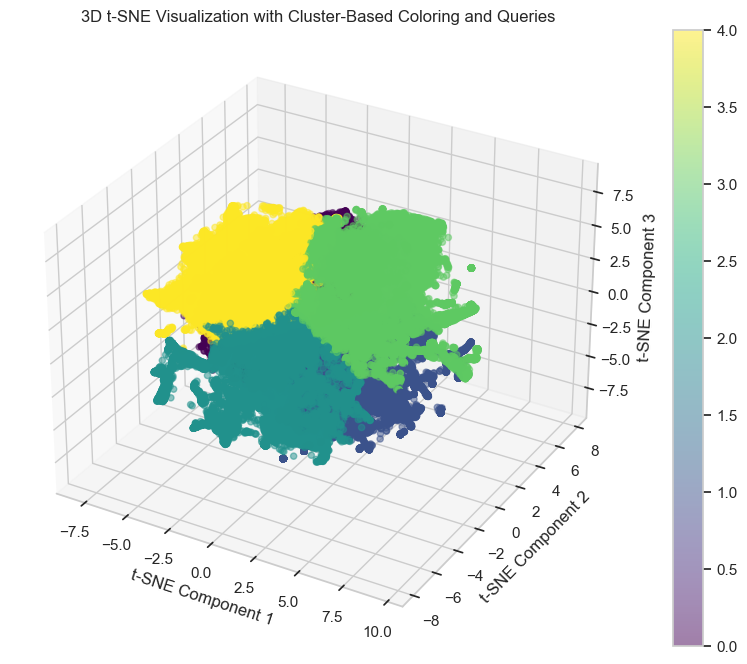

In [32]:
def optimized_plot_embeddings_3D_multiple_views(embeddings_dict, queries, index, top_n=5):
    # Extract embeddings and corresponding words
    words, embeddings = zip(*[(word, data['embedding']) for word, data in embeddings_dict.items() if data['embedding'] is not None])

    # Randomly sample 10k embeddings
    sample_size = min(10000, len(embeddings))
    sampled_indices = random.sample(range(len(embeddings)), sample_size)
    sampled_embeddings = [embeddings[i] for i in sampled_indices]

    # Initialize lists for query embeddings
    query_embeddings = []

    # Process each query
    for query in queries:
        # Get the query embedding
        query_embedding = embeddings_dict.get(query, {'embedding': None})['embedding']
        if query_embedding is None:
            query_embedding = embed_words_batch([query])[0]  # Replace with your actual embedding function
        query_embeddings.append(query_embedding)

    # Combine sampled embeddings and query embeddings
    extended_embeddings = np.vstack(sampled_embeddings + query_embeddings)

    # TSNE for dimensionality reduction to 3 components
    tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(extended_embeddings)

    # KMeans for cluster-based coloring
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(tsne_results[:-1-len(queries)])

    # Plotting multiple views
    sns.set(style='whitegrid')
    fig = plt.figure(figsize=(18, 6))

    # Define different azimuth angles for horizontal rotation
    azimuths = [0, 60, 120, 180, 240, 300]
    for i, azim in enumerate(azimuths):
        ax = fig.add_subplot(1, len(azimuths), i+1, projection='3d')

        # Scatter plot for sampled embeddings with cluster coloring
        ax.scatter(tsne_results[:-1-len(queries), 0], 
                   tsne_results[:-1-len(queries), 1], 
                   tsne_results[:-1-len(queries), 2], 
                   c=clusters, alpha=0.5, cmap='viridis')

        # Highlight the queries
        for j, query in enumerate(queries):
            ax.scatter(tsne_results[-1-len(queries)+j, 0], 
                       tsne_results[-1-len(queries)+j, 1], 
                       tsne_results[-1-len(queries)+j, 2], 
                       color='blue', marker='X', s=100)
            ax.text(tsne_results[-1-len(queries)+j, 0], 
                    tsne_results[-1-len(queries)+j, 1], 
                    tsne_results[-1-len(queries)+j, 2], 
                    query, color='black')

        ax.set_title(f'View {i+1} (Azimuth={azim}°)')
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.set_zlabel('t-SNE Component 3')
        ax.view_init(elev=30, azim=azim)

    plt.tight_layout()
    plt.show()

# Example usage with multiple queries
optimized_plot_embeddings_3D_multiple_views(embeddings_dict, [], annoy_index, top_n=5)


In [18]:
import plotly.graph_objects as go
import numpy as np
import seaborn as sns

def plot_embeddings_3d_interactive(embeddings_dict, query, index, top_n=5):
    words, embeddings = zip(*[(word, data['embedding']) for word, data in embeddings_dict.items() if data['embedding'] is not None])
    query_embedding = embeddings_dict.get(query, {'embedding': None})['embedding']
    
    if query_embedding is None:
        query_embedding = embed_words_batch([query])[0]

    extended_embeddings = np.vstack(embeddings + (query_embedding,))

    tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(extended_embeddings)

    # Convert Seaborn colors to RGB format acceptable by Plotly
    colors = sns.color_palette("hsv", len(tsne_results))
    colors_rgb = ['rgb' + str(tuple(int(x*255) for x in color)) for color in colors]

    fig = go.Figure()

    # Plot all points with unique colors
    for i, (x, y, z) in enumerate(tsne_results[:-1]):
        fig.add_trace(go.Scatter3d(
            x=[x],
            y=[y],
            z=[z],
            mode='markers',
            marker=dict(size=5, color=colors_rgb[i], opacity=0.5)
        ))

    # Highlight and label the query point
    fig.add_trace(go.Scatter3d(
        x=[tsne_results[-1, 0]],
        y=[tsne_results[-1, 1]],
        z=[tsne_results[-1, 2]],
        mode='markers+text',
        marker=dict(size=8, color='blue'),
        text=[query],
        textposition="bottom center"
    ))

    # Find, highlight, and label nearest neighbors
    indices = index.get_nns_by_vector(query_embedding, top_n)
    for i in indices:
        fig.add_trace(go.Scatter3d(
            x=[tsne_results[i, 0]],
            y=[tsne_results[i, 1]],
            z=[tsne_results[i, 2]],
            mode='markers+text',
            marker=dict(size=8, color='red'),
            text=[words[i]],
            textposition="bottom center"
        ))

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title='t-SNE Component 1',
            yaxis_title='t-SNE Component 2',
            zaxis_title='t-SNE Component 3'
        )
    )

    fig.show()


# Assuming embeddings_dict and annoy_index are already created
# Example query word
query_word = "gpt4"  # Replace with your query word

# Plotting the embeddings in 3D with an interactive plot and unique colors
plot_embeddings_3d_interactive(embeddings_dict, query_word, annoy_index, top_n=25)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 527902 samples in 0.070s...
